In [1]:
#!pip install yfinance
#!pip install pandas-ta

In [2]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [4]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="30d", interval="15m")
#df_analisys = yf.download('^GSPC', interval="5m", start="2022-02-16", end="2022-03-03")

df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(781, 7)


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-01-27 09:30:00-05:00,4380.580078,4412.330078,4380.580078,4411.450195,4411.450195,114210975
1,2022-01-27 09:45:00-05:00,4412.160156,4426.310059,4406.129883,4416.330078,4416.330078,157150563
2,2022-01-27 10:00:00-05:00,4416.250000,4428.740234,4400.330078,4426.200195,4426.200195,120682154
3,2022-01-27 10:15:00-05:00,4426.089844,4427.729980,4389.509766,4389.509766,4389.509766,115150727
4,2022-01-27 10:30:00-05:00,4389.319824,4392.950195,4374.259766,4392.810059,4392.810059,115498034
...,...,...,...,...,...,...,...
776,2022-03-10 15:00:00-05:00,4260.669922,4261.669922,4247.229980,4256.229980,4256.229980,72411000
777,2022-03-10 15:15:00-05:00,4256.189941,4258.609863,4245.859863,4253.140137,4253.140137,81758000
778,2022-03-10 15:30:00-05:00,4253.089844,4258.580078,4246.799805,4253.569824,4253.569824,104446000
779,2022-03-10 15:45:00-05:00,4253.520020,4268.279785,4248.669922,4259.189941,4259.189941,265628000


In [5]:
df_analisys.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_raw' + '.pkl')
print(df_analisys.shape)

(781, 7)


In [7]:
#df_analisys[ (df_analisys['Datetime']>=dt.datetime(2022,3,3,15,30))]

# Candles computations

In [8]:
#Fixes the trading date
df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
df_analisys['Datetime']

0     2022-01-27 09:30:00
1     2022-01-27 09:45:00
2     2022-01-27 10:00:00
3     2022-01-27 10:15:00
4     2022-01-27 10:30:00
              ...        
776   2022-03-10 15:00:00
777   2022-03-10 15:15:00
778   2022-03-10 15:30:00
779   2022-03-10 15:45:00
780   2022-03-10 16:00:00
Name: Datetime, Length: 781, dtype: datetime64[ns]

In [9]:
df_analisys['date'] = df_analisys['Datetime'].apply(lambda x: x.date())
df_analisys['date']

0      2022-01-27
1      2022-01-27
2      2022-01-27
3      2022-01-27
4      2022-01-27
          ...    
776    2022-03-10
777    2022-03-10
778    2022-03-10
779    2022-03-10
780    2022-03-10
Name: date, Length: 781, dtype: object

In [10]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2022-01-27 09:30:00,4380.580078,4412.330078,4380.580078,4411.450195,4411.450195,114210975,2022-01-27,30.870117,30.870117,0.879883,0.000000
1,2022-01-27 09:45:00,4412.160156,4426.310059,4406.129883,4416.330078,4416.330078,157150563,2022-01-27,4.169922,4.169922,9.979980,6.030273
2,2022-01-27 10:00:00,4416.250000,4428.740234,4400.330078,4426.200195,4426.200195,120682154,2022-01-27,9.950195,9.950195,2.540039,15.919922
3,2022-01-27 10:15:00,4426.089844,4427.729980,4389.509766,4389.509766,4389.509766,115150727,2022-01-27,-36.580078,36.580078,1.640137,0.000000
4,2022-01-27 10:30:00,4389.319824,4392.950195,4374.259766,4392.810059,4392.810059,115498034,2022-01-27,3.490234,3.490234,0.140137,15.060059
5,2022-01-27 10:45:00,4392.770020,4407.410156,4385.060059,4406.290039,4406.290039,95580774,2022-01-27,13.520020,13.520020,1.120117,7.709961
6,2022-01-27 11:00:00,4406.180176,4416.950195,4401.160156,4411.870117,4411.870117,91731568,2022-01-27,5.689941,5.689941,5.080078,5.020020
7,2022-01-27 11:15:00,4412.109863,4412.109863,4385.879883,4389.799805,4389.799805,88036177,2022-01-27,-22.310059,22.310059,0.000000,3.919922
8,2022-01-27 11:30:00,4389.879883,4410.430176,4389.459961,4403.770020,4403.770020,79594000,2022-01-27,13.890137,13.890137,6.660156,0.419922
9,2022-01-27 11:45:00,4403.859863,4408.319824,4398.279785,4403.379883,4403.379883,67056000,2022-01-27,-0.479980,0.479980,4.459961,5.100098


In [11]:
#Computes candles color
df_analisys['body_disposal']=0
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1      0            384
0      1            397


# MACD and EMA indicators

In [12]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
776,0.542628,4.819689,-4.277060
777,1.248073,4.420106,-3.172034
778,1.820825,3.994287,-2.173462
779,2.697141,3.896483,-1.199341


In [13]:
ewm50 = df_analisys['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys['diff_ewm50'] = df_analisys['Close'] - ewm50
df_analisys['diff_ewm200'] = df_analisys['Close'] - ewm200

df_analisys

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-01-27 09:30:00,4380.580078,4412.330078,4380.580078,4411.450195,4411.450195,114210975,2022-01-27,30.870117,30.870117,0.879883,0.000000,1,NaN,NaN,NaN,NaN,NaN
1,2022-01-27 09:45:00,4412.160156,4426.310059,4406.129883,4416.330078,4416.330078,157150563,2022-01-27,4.169922,4.169922,9.979980,6.030273,1,NaN,NaN,NaN,NaN,NaN
2,2022-01-27 10:00:00,4416.250000,4428.740234,4400.330078,4426.200195,4426.200195,120682154,2022-01-27,9.950195,9.950195,2.540039,15.919922,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-27 10:15:00,4426.089844,4427.729980,4389.509766,4389.509766,4389.509766,115150727,2022-01-27,-36.580078,36.580078,1.640137,0.000000,0,NaN,NaN,NaN,NaN,NaN
4,2022-01-27 10:30:00,4389.319824,4392.950195,4374.259766,4392.810059,4392.810059,115498034,2022-01-27,3.490234,3.490234,0.140137,15.060059,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-10 15:00:00,4260.669922,4261.669922,4247.229980,4256.229980,4256.229980,72411000,2022-03-10,-4.439941,4.439941,1.000000,9.000000,0,0.542628,4.819689,-4.277060,10.506145,-22.560685
777,2022-03-10 15:15:00,4256.189941,4258.609863,4245.859863,4253.140137,4253.140137,81758000,2022-03-10,-3.049805,3.049805,2.419922,7.280273,0,1.248073,4.420106,-3.172034,7.125466,-25.395299
778,2022-03-10 15:30:00,4253.089844,4258.580078,4246.799805,4253.569824,4253.569824,104446000,2022-03-10,0.479980,0.479980,5.010254,6.290039,1,1.820825,3.994287,-2.173462,7.258873,-24.717198
779,2022-03-10 15:45:00,4253.520020,4268.279785,4248.669922,4259.189941,4259.189941,265628000,2022-03-10,5.669922,5.669922,9.089844,4.850098,1,2.697141,3.896483,-1.199341,12.373932,-18.907060


In [14]:
#Keeps only the data where MACD is available

#df_analisys = df_analisys[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys.shape)
print(df_analisys.shape)

df_analisys

(781, 18)
(781, 18)


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-01-27 09:30:00,4380.580078,4412.330078,4380.580078,4411.450195,4411.450195,114210975,2022-01-27,30.870117,30.870117,0.879883,0.000000,1,NaN,NaN,NaN,NaN,NaN
1,2022-01-27 09:45:00,4412.160156,4426.310059,4406.129883,4416.330078,4416.330078,157150563,2022-01-27,4.169922,4.169922,9.979980,6.030273,1,NaN,NaN,NaN,NaN,NaN
2,2022-01-27 10:00:00,4416.250000,4428.740234,4400.330078,4426.200195,4426.200195,120682154,2022-01-27,9.950195,9.950195,2.540039,15.919922,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-27 10:15:00,4426.089844,4427.729980,4389.509766,4389.509766,4389.509766,115150727,2022-01-27,-36.580078,36.580078,1.640137,0.000000,0,NaN,NaN,NaN,NaN,NaN
4,2022-01-27 10:30:00,4389.319824,4392.950195,4374.259766,4392.810059,4392.810059,115498034,2022-01-27,3.490234,3.490234,0.140137,15.060059,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-10 15:00:00,4260.669922,4261.669922,4247.229980,4256.229980,4256.229980,72411000,2022-03-10,-4.439941,4.439941,1.000000,9.000000,0,0.542628,4.819689,-4.277060,10.506145,-22.560685
777,2022-03-10 15:15:00,4256.189941,4258.609863,4245.859863,4253.140137,4253.140137,81758000,2022-03-10,-3.049805,3.049805,2.419922,7.280273,0,1.248073,4.420106,-3.172034,7.125466,-25.395299
778,2022-03-10 15:30:00,4253.089844,4258.580078,4246.799805,4253.569824,4253.569824,104446000,2022-03-10,0.479980,0.479980,5.010254,6.290039,1,1.820825,3.994287,-2.173462,7.258873,-24.717198
779,2022-03-10 15:45:00,4253.520020,4268.279785,4248.669922,4259.189941,4259.189941,265628000,2022-03-10,5.669922,5.669922,9.089844,4.850098,1,2.697141,3.896483,-1.199341,12.373932,-18.907060


In [15]:
df_varbins = df_analisys[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                     index  diff_bins
0                   00-nan         49
2   01-(-149.647, -69.335]         37
12    02-(-69.335, -58.25]         37
17    03-(-58.25, -49.865]         36
4    04-(-49.865, -41.936]         37
16   05-(-41.936, -35.801]         36
5    06-(-35.801, -29.988]         37
13   07-(-29.988, -25.091]         36
6    08-(-25.091, -20.169]         37
14   09-(-20.169, -13.135]         36
1     10-(-13.135, -6.692]         37
8     11-(-6.692, -0.0256]         37
18     12-(-0.0256, 8.155]         36
3       13-(8.155, 14.156]         37
19     14-(14.156, 20.002]         36
7      15-(20.002, 28.171]         37
20     16-(28.171, 37.767]         36
9      17-(37.767, 44.289]         37
15     18-(44.289, 52.456]         36
11     19-(52.456, 65.569]         37
10     20-(65.569, 104.25]         37
Absolute mean difference with:  diff_ewm50    35.656106
dtype: float64
Absolute mean difference with:  diff_ewm200    56.277979
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data preparation

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [17]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_close_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    ls_results = []
    
    last_ss_close = X_ss1[-1:][0][0]
    mean_last3_ss_close = X_ss1[-3:].mean()
    
    ls_results.append(last_ss_close)
    ls_results.append(mean_last3_ss_close)
    
    ls_columns = [
        'last_ss_close',
        'mean_last3_ss_close',
    ]
    
    ###############################################################################################
    #Computes slopes before the last close
    
    y = X_ss1[-3:]
    x = np.array([range(0,len(y))]).reshape(-1,1)


    linreg = LinearRegression()
    linreg.fit(x,y)
    slope_ss_close = linreg.coef_[0][0]

    ls_results.append(slope_ss_close)

    ls_columns = ls_columns + [
        'slope_ss_close',
    ]
    
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    df_results
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata1, df_results],axis=1,sort=False)
    df_close_info['Datetime'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss1_close_100,ss1_close_99,ss1_close_98,ss1_close_97,ss1_close_96,ss1_close_95,ss1_close_94,ss1_close_93,ss1_close_92,ss1_close_91,...,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1,last_ss_close,mean_last3_ss_close,slope_ss_close,Datetime
0,0.708148,0.895877,0.957923,0.486552,0.269717,0.138654,-0.109219,-0.173166,-0.109853,-0.162083,...,0.687899,0.548288,0.450475,0.464077,0.641991,0.652440,0.652440,5.861692e-01,0.094181,2022-03-10 16:00:00
1,0.871594,0.704722,0.892133,0.954074,0.483502,0.267035,0.136194,-0.111259,-0.175097,-0.111892,...,0.352353,0.684508,0.545134,0.447486,0.461065,0.638677,0.638677,5.157429e-01,0.095596,2022-03-10 15:45:00
2,0.851001,0.868040,0.701436,0.888546,0.950387,0.480571,0.264451,0.133821,-0.113235,-0.176971,...,0.427250,0.349633,0.681254,0.542104,0.444613,0.458170,0.458170,4.816288e-01,-0.041967,2022-03-10 15:30:00
3,1.108995,0.839998,0.856950,0.691208,0.877349,0.938870,0.471486,0.256484,0.126530,-0.119247,...,0.224774,0.418440,0.341225,0.671130,0.532700,0.435713,0.435713,5.465145e-01,-0.117708,2022-03-10 15:15:00
4,1.422022,1.088661,0.822170,0.838963,0.674765,0.859173,0.920121,0.457090,0.244091,0.115348,...,-0.008112,0.212676,0.404539,0.328043,0.654875,0.517734,0.517734,5.002171e-01,0.094846,2022-03-10 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.298926,0.647058,1.351195,-1.266311,-1.030867,-1.030867,-3.153278e-01,-1.191031,2022-01-27 10:30:00
777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.043012,0.406378,1.141327,-1.590717,-1.590717,-1.433733e-02,-0.998547,2022-01-27 10:15:00
778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.066471,-0.271114,1.337586,1.337586,4.944193e-14,1.202029,2022-01-27 10:00:00
779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.000000,1.000000,1.000000,0.000000e+00,2.000000,2022-01-27 09:45:00


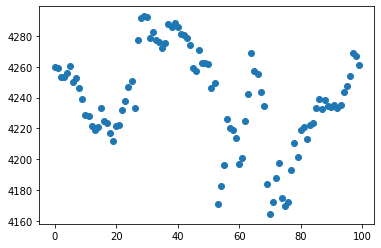

<function matplotlib.pyplot.show(*args, **kw)>

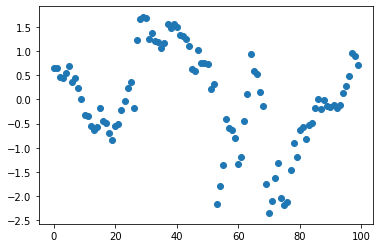

In [18]:
data = df_analisys.iloc[-100:,:]['Close'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_close_info_01.iloc[0,:][['ss1_close_' + str(x) for x in range(1,101) ]]
plt.scatter(range(0,len(data)), data)
plt.show


In [19]:
ls_ss1vars = ['ss1_close_' + str(x) for x in range(100,0,-1)]
len(ls_ss1vars)

100

In [20]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss1vars] = df_close_info_01[ls_ss1vars].astype(float)
df_close_info_01[ls_columns] = df_close_info_01[ls_columns].astype(float)


In [21]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_columns + ls_ss1vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Columns: 103 entries, last_ss_close to ss1_close_1
dtypes: float64(103)
memory usage: 554.1 KB


In [22]:
#Defines X vector to all process

X = df_close_info_01[ls_columns + ls_ss1vars]
print(X.shape)


(682, 103)


In [23]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough",ls_columns),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [24]:
Xtr.shape

(682, 6)

In [25]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_close_c1','ss1_close_c2','ss1_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_columns + ls_ss1pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(682, 6)


,last_ss_close,mean_last3_ss_close,slope_ss_close,ss1_close_c1,ss1_close_c2,ss1_close_c3
0,0.652440,0.586169,0.094181,5.506050,0.227443,-4.567218
1,0.638677,0.515743,0.095596,5.322780,-0.167993,-5.036287
2,0.458170,0.481629,-0.041967,5.130833,-0.561665,-5.439490
3,0.435713,0.546515,-0.117708,4.898885,-1.014638,-5.777658
4,0.517734,0.500217,0.094846,4.604126,-1.504686,-6.080393
...,...,...,...,...,...,...
677,1.522809,1.468361,0.049692,10.719761,-1.941010,-0.467463
678,1.495031,1.439970,0.064693,10.658818,-2.236212,-0.635302
679,1.491439,1.373404,0.129720,10.538459,-2.613414,-0.871554
680,1.429218,1.315378,0.087438,10.419984,-2.975661,-1.055439


In [26]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['Datetime'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,Datetime,last_ss_close,mean_last3_ss_close,slope_ss_close,ss1_close_c1,ss1_close_c2,ss1_close_c3
0,2022-03-10 16:00:00,0.652440,0.586169,0.094181,5.506050,0.227443,-4.567218
1,2022-03-10 15:45:00,0.638677,0.515743,0.095596,5.322780,-0.167993,-5.036287
2,2022-03-10 15:30:00,0.458170,0.481629,-0.041967,5.130833,-0.561665,-5.439490
3,2022-03-10 15:15:00,0.435713,0.546515,-0.117708,4.898885,-1.014638,-5.777658
4,2022-03-10 15:00:00,0.517734,0.500217,0.094846,4.604126,-1.504686,-6.080393
...,...,...,...,...,...,...,...
677,2022-02-01 15:45:00,1.522809,1.468361,0.049692,10.719761,-1.941010,-0.467463
678,2022-02-01 15:30:00,1.495031,1.439970,0.064693,10.658818,-2.236212,-0.635302
679,2022-02-01 15:15:00,1.491439,1.373404,0.129720,10.538459,-2.613414,-0.871554
680,2022-02-01 15:00:00,1.429218,1.315378,0.087438,10.419984,-2.975661,-1.055439


In [27]:
pd.concat([df_close_info_01[['Datetime'] +ls_columns].iloc[0:1,:],
           df_close_info_01[['Datetime'] +ls_columns].iloc[0:1,:]],axis=0)

,Datetime,last_ss_close,mean_last3_ss_close,slope_ss_close
0,2022-03-10 16:00:00,0.65244,0.586169,0.094181
0,2022-03-10 16:00:00,0.65244,0.586169,0.094181


# VOLUME DATA

In [28]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys.iloc[-(nro_close_lag + i):,][['Volume']]
        Datetime = df_analisys.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys.iloc[-(nro_close_lag + i):-i,][['Volume']]
        Datetime = df_analisys.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)
    
    last_ss_volume = X_ss1[-1:][0][0]
    mean_last3_ss_vols = X_ss1[-3:].mean()
    
    # Obtains the df of variables of close lags
    ls_columns = ['ss1_vols_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    
    
    ###############################################################################################
    ls_results = []
    ls_results.append(last_ss_volume)
    ls_results.append(mean_last3_ss_vols)
    
    ls_columns = [
        'last_ss_volume',
        'mean_last3_ss_vols',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes slopes before the last close
    y = X_ss1
    x = np.array([range(0,len(X_ss1))]).reshape(-1, 1)
    x_new = np.array([range(len(X),len(X)+1)]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y)
    yhat = linreg.predict(x)
    pred_ss_vol = linreg.predict(x_new)[0][0]
    
    ls_results.append(pred_ss_vol)
    
    ls_columns = ls_columns + [
        'pred_ss_vol',
    ]
    ###############################################################################################
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    
    df_vols_info = pd.concat([df_ssdata1,df_results],axis=1,sort=False)
    df_vols_info['Datetime'] = Datetime
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
    ###############################################################################################
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss1_vols_100,ss1_vols_99,ss1_vols_98,ss1_vols_97,ss1_vols_96,ss1_vols_95,ss1_vols_94,ss1_vols_93,ss1_vols_92,ss1_vols_91,...,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,Datetime
0,0.288692,0.112584,-0.217201,-0.100070,-0.205492,-0.263557,-0.088120,-0.299722,-0.281158,-0.386412,...,-0.644092,-0.587936,-0.414759,0.005592,2.991887,2.991887,2.991887,1.996455e+00,-0.221183,2022-03-10 16:00:00
1,0.538475,0.328459,0.144076,-0.201205,-0.078571,-0.188945,-0.249739,-0.066059,-0.287604,-0.268167,...,-0.765436,-0.648156,-0.589360,-0.408047,0.032057,3.158675,3.158675,9.275615e-01,-0.342817,2022-03-10 15:45:00
2,0.528414,0.595308,0.374149,0.179982,-0.183620,-0.054478,-0.170710,-0.234729,-0.041303,-0.274603,...,-0.905073,-0.777790,-0.654287,-0.592371,-0.401437,0.062019,0.062019,-3.105964e-01,-0.477817,2022-03-10 15:30:00
3,0.717535,0.520426,0.587147,0.366559,0.172894,-0.189768,-0.060961,-0.176892,-0.240746,-0.047819,...,-0.608649,-0.909357,-0.782403,-0.659219,-0.597463,-0.407022,-0.407022,-5.545682e-01,-0.500200,2022-03-10 15:15:00
4,1.665466,0.687125,0.492634,0.558468,0.340810,0.149718,-0.208128,-0.081030,-0.195422,-0.258428,...,-0.888726,-0.621444,-0.918158,-0.792891,-0.671342,-0.610407,-0.610407,-6.915466e-01,-0.531854,2022-03-10 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.627367,1.981089,-0.234261,-0.570279,-0.549182,-0.549182,-4.512408e-01,-0.718499,2022-01-27 10:30:00
777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.711275,1.715064,-0.345615,-0.658174,-0.658174,2.370917e-01,-0.475344,2022-01-27 10:15:00
778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.871342,1.400333,-0.528991,-0.528991,-2.590520e-16,0.342351,2022-01-27 10:00:00
779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.000000,1.000000,1.000000,0.000000e+00,3.000000,2022-01-27 09:45:00


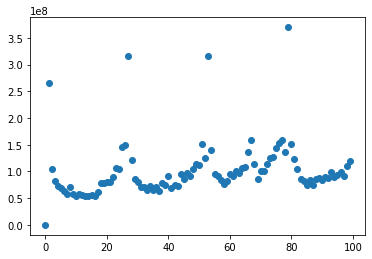

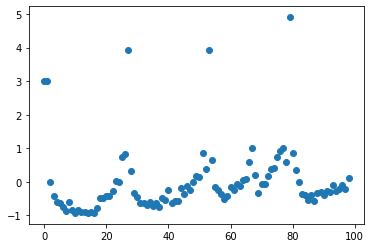

,Datetime,Volume
769,2022-03-10 13:15:00,58459000
770,2022-03-10 13:30:00,53610000
771,2022-03-10 13:45:00,58567000
772,2022-03-10 14:00:00,71862000
773,2022-03-10 14:15:00,57103000
774,2022-03-10 14:30:00,63334000
775,2022-03-10 14:45:00,69380000
776,2022-03-10 15:00:00,72411000
777,2022-03-10 15:15:00,81758000
778,2022-03-10 15:30:00,104446000


In [29]:
data = df_analisys.iloc[-100:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss1_vols_' + str(x) for x in range(1,100) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

df_analisys[['Datetime','Volume']].iloc[-12:,]

In [30]:
# Create variable names lists to naming columns

ls_ss1vars = ['ss1_vols_' + str(x) for x in range(100,0,-1)]
len(ls_ss1vars)


100

In [31]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss1vars] = df_vols_info_01[ls_ss1vars].astype(float)
df_vols_info_01[ls_columns] = df_vols_info_01[ls_columns].astype(float)


In [32]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01.info()



(682, 104)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Columns: 104 entries, ss1_vols_100 to Datetime
dtypes: datetime64[ns](1), float64(103)
memory usage: 554.2 KB


In [33]:
#Defines X vector to all process

X = df_vols_info_01[ls_ss1vars + ls_columns]
print(X.shape)


(682, 103)


In [34]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_columns),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [35]:
Xtr.shape

(682, 6)

In [36]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_columns + ls_ss1pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(682, 6)


,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,2.991887,1.996455,-0.221183,0.745386,-5.167410,-3.664541
1,3.158675,0.927562,-0.342817,2.055483,-4.677972,-2.158650
2,0.062019,-0.310596,-0.477817,3.326903,-3.893519,-0.000738
3,-0.407022,-0.554568,-0.500200,4.258475,-3.004045,1.845451
4,-0.610407,-0.691547,-0.531854,5.016270,-2.025324,3.306898
...,...,...,...,...,...,...
677,3.919546,1.354582,-0.105786,1.815497,-5.327164,-1.890329
678,0.428424,0.005733,-0.261276,3.321330,-4.650626,0.025767
679,-0.199703,-0.360016,-0.294684,4.407203,-3.687556,1.562692
680,-0.230414,-0.508314,-0.329065,5.291945,-2.610184,2.748895


In [37]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['Datetime'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,Datetime,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,2022-03-10 16:00:00,2.991887,1.996455,-0.221183,0.745386,-5.167410,-3.664541
1,2022-03-10 15:45:00,3.158675,0.927562,-0.342817,2.055483,-4.677972,-2.158650
2,2022-03-10 15:30:00,0.062019,-0.310596,-0.477817,3.326903,-3.893519,-0.000738
3,2022-03-10 15:15:00,-0.407022,-0.554568,-0.500200,4.258475,-3.004045,1.845451
4,2022-03-10 15:00:00,-0.610407,-0.691547,-0.531854,5.016270,-2.025324,3.306898
...,...,...,...,...,...,...,...
677,2022-02-01 15:45:00,3.919546,1.354582,-0.105786,1.815497,-5.327164,-1.890329
678,2022-02-01 15:30:00,0.428424,0.005733,-0.261276,3.321330,-4.650626,0.025767
679,2022-02-01 15:15:00,-0.199703,-0.360016,-0.294684,4.407203,-3.687556,1.562692
680,2022-02-01 15:00:00,-0.230414,-0.508314,-0.329065,5.291945,-2.610184,2.748895


In [38]:
pd.concat([df_vols_info_tr_01[['Datetime'] +ls_columns].iloc[0:1,:],
           df_vols_info_01[['Datetime'] +ls_columns].iloc[0:1,:]],axis=0)

,Datetime,last_ss_volume,mean_last3_ss_vols,pred_ss_vol
0,2022-03-10 16:00:00,2.991887,1.996455,-0.221183
0,2022-03-10 16:00:00,2.991887,1.996455,-0.221183


## (Volume) Additional calculations

In [39]:
#Computes Target signal

df_input = df_vols_info_tr_01.copy()
nro_rows = len(df_input)

for i in range(0,nro_rows):
#for i in range(0,3):
    
    vol_threshold = 0.2
    
    #Searches for the after indexes where the profit threshold is fullfilled 
    
    s_obs = df_input['last_ss_volume'].iloc[(i+1):]

    s_threshold = (s_obs > vol_threshold)
    idxs = s_threshold[s_threshold].index

    keepcols = ['Datetime','last_ss_volume']
    
    try:
        target_idx = [min(idxs)]
        df_data = df_input.iloc[df_input.index==target_idx[0]]
    except:
        target_idx = []
        df_data = pd.DataFrame(columns=keepcols)

    df_data = df_data[keepcols]
    
    Datetime = df_input['Datetime'][i]
    
    try:
        low_movs = len(s_obs[s_obs.index<=target_idx[0]])
    except:
        low_movs = 0

    dic_rencols = {
        'Datetime':'Datetime2',
        'last_ss_volume': 'last_ss_volume2',
    }

    df_data = df_data.rename(columns=dic_rencols)
    df_data['Datetime'] = Datetime
    df_data['movs_low_vols'] = low_movs

    if i == 0:
        df_low_movs =df_data.copy()
    else:
        df_low_movs =df_low_movs.append(df_data).copy()


        
df_movs_low_vols = df_low_movs.reset_index(drop=True)
df_movs_low_vols

,Datetime2,last_ss_volume2,Datetime,movs_low_vols
0,2022-03-10 15:45:00,3.158675,2022-03-10 16:00:00,1
1,2022-03-10 09:45:00,0.689422,2022-03-10 15:45:00,24
2,2022-03-10 09:45:00,0.689422,2022-03-10 15:30:00,23
3,2022-03-10 09:45:00,0.689422,2022-03-10 15:15:00,22
4,2022-03-10 09:45:00,0.689422,2022-03-10 15:00:00,21
...,...,...,...,...
673,2022-02-02 10:00:00,0.655000,2022-02-02 10:15:00,1
674,2022-02-02 09:45:00,1.547766,2022-02-02 10:00:00,1
675,2022-02-02 09:30:00,0.657183,2022-02-02 09:45:00,1
676,2022-02-01 15:45:00,3.919546,2022-02-02 09:30:00,1


# Trading insights

In [40]:
for c in df_analisys.columns.tolist():
    print(c)

Datetime
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [46]:
# Prepares previos moements info as input variables
pd.options.mode.chained_assignment = None  # default='warn'


for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 21
    
    ls_vars = [
        'Datetime',
        'Close',
        'Volume',
        'abs_body_size',
        'upper_tail_size',
        'lower_tail_size',
        'body_disposal',
        'MACD_12_26_9',
        'MACDs_12_26_9',
        'MACDh_12_26_9',
    ]
    
    
    df_input = df_analisys[ls_vars]
    
    ls_results = []

    if i==0:
        X = df_input.iloc[-(nro_close_lag + i):,:]
        Datetime = df_input.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_input.iloc[-(nro_close_lag + i):-i,:]
        Datetime = df_input.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)]['Volume'] == 0:
        val = X.loc[max(X.index)-1]['Volume']
        X.loc[max(X.index),'Volume'] = val

    ###############################################################################################

    
    ###############################################################################################
    #Computes slopes before the last close
    
    def weighted_preds(Xp,var,var_weight):
    
        Xp['weight1'] = 1/len(X)
        Xp['weight1'] = Xp['weight1'].cumsum()
        Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

        Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

        Xp['weight'] = Xp['weight1']*Xp['weight2']
        Xp['weight'] = Xp['weight']/sum(Xp['weight'])

        y = Xp[var].values.reshape(-1, 1)
        w = Xp['weight'].values.reshape(len(Xp),)
        x = np.array([range(0,len(Xp))]).reshape(-1, 1)

        linreg = LinearRegression()

        linreg.fit(x,y,w)
        slope_close = linreg.coef_[0][0]
        yhat = linreg.predict(x)

        Xp['yhat'] = yhat
        Xp['yhat_sup'] = yhat + yhat.std()
        Xp['yhat_inf'] = yhat - yhat.std()
        Xp['slope'] = math.atan(slope_close)*(180/math.pi)

        Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

        return Xo

    Xp = X[['Close','Volume']]
    Xout = weighted_preds(Xp,'Close','Volume')
    
    Xout = Xout.rename(columns={'yhat':'pred_close_long',
                                'yhat_sup':'pred_close_long_upper',
                                'yhat_inf':'pred_close_long_lower',
                                'slope':'slope_close_long'})

    Xout = pd.concat([Xp,Xout],axis=1)


    Xp = X.iloc[-8:]
    Xout2 = weighted_preds(Xp,'Close','Volume')
    Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short',
                                                    'slope':'slope_close_short'})

    Xout = pd.concat([Xout,Xout2],axis=1)
    Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2



    actual_close = X['Close'].values[-1]
    pred_close_long = Xout['pred_close_long'].values[-1]
    pred_close_long_upper = Xout['pred_close_long_upper'].values[-1]
    pred_close_long_lower = Xout['pred_close_long_lower'].values[-1]
    
    slope_close_long = Xout['slope_close_long'].values[-1]
    slope_close_short = Xout['slope_close_short'].values[-1]
    
    diff_closewpred_close =  actual_close - pred_close_long
    pp_close_interval_distance = abs(diff_closewpred_close)/abs(pred_close_long_upper-pred_close_long)
    
    ls_results.append(slope_close_long)
    ls_results.append(slope_close_short)
    ls_results.append(diff_closewpred_close)
    ls_results.append(pp_close_interval_distance)
    
    ls_columns = [
        'slope_close_long',
        'slope_close_short',
        'diff_closewpred_close',
        'pp_close_interval_distance',
    ]
    ###############################################################################################
    
    
    
    ###############################################################################################
    df_macd_l4 = X[['MACD_12_26_9','MACDs_12_26_9','MACDh_12_26_9','Volume']].iloc[-5:,]

    df_macd_l4['neg'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']<0,'neg'] = 1

    df_macd_l4['pos'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']>=0,'pos'] = 1

    recent_macd_cross = 0
    if max(df_macd_l4['neg']) + max(df_macd_l4['pos']) == 2:
        recent_macd_cross = 1
        
    mean_last_macd = df_macd_l4['MACD_12_26_9'].mean()
    mean_last_macdh = df_macd_l4['MACDh_12_26_9'].mean()

        
    Xp = df_macd_l4
    
    try:
        Xout = weighted_preds(Xp,'MACD_12_26_9','Volume')

        slope = Xout['slope'].values
        slope_macd = slope[-1]
    except:
        slope = None
        slope_macd = None
    
    
    ls_results.append(recent_macd_cross)
    ls_results.append(slope_macd)
    ls_results.append(mean_last_macd)
    ls_results.append(mean_last_macdh)
    
    ls_columns = ls_columns + [
        'recent_macd_cross',
        'slope_macd',
        'mean_last_macd',
        'mean_last_macdh',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes pp for the associated volumes
    X['pp_vol'] = X['Volume'] / sum(X['Volume'])
    pp_vol_last2 = sum(X['pp_vol'].iloc[-2:])
    ls_results.append(pp_vol_last2)
    
    ls_columns = ls_columns + [
        'pp_vol_last2']
    ###############################################################################################
    
    ###############################################################################################
    #Computes pp for the associated volumes
    X['pp_body_size'] = X['abs_body_size'] / sum(X['abs_body_size'])
    pp_body_size_last2 = sum(X['pp_body_size'].iloc[-2:])
    ls_results.append(pp_body_size_last2)
    
    ls_columns = ls_columns + [
        'pp_body_size_last2']
    ###############################################################################################
    
    
    
    ###############################################################################################
    #Computes statistics of body sizes
    
    if len(X[X['body_disposal']==1])>0:
        mean_green_candles_sizes = X[X['body_disposal']==1]['abs_body_size'].mean()
        std_green_candles_sizes = X[X['body_disposal']==1]['abs_body_size'].std()
        pp_green_candles_vols = X[X['body_disposal']==1]['pp_vol'].sum()
    else:
        mean_green_candles_sizes = 0
        std_green_candles_sizes = 0
        pp_green_candles_vols = 0
        
    if str(std_green_candles_sizes) in ['nan','NaN']:
        std_green_candles_sizes = 0
    
    if len(X[X['body_disposal']==0])>0:
        mean_red_candles_sizes = X[X['body_disposal']==0]['abs_body_size'].mean()
        std_red_candles_sizes = X[X['body_disposal']==0]['abs_body_size'].std()
        pp_red_candles_vols = X[X['body_disposal']==0]['pp_vol'].sum()
    else:
        mean_red_candles_sizes = 0
        std_red_candles_sizes = 0
        pp_red_candles_vols = 0
        
    if str(std_red_candles_sizes) in ['nan','NaN']:
        std_red_candles_sizes = 0

    
    Xp = X[['body_disposal','pp_vol','pp_body_size']].iloc[-2:]

    pp_green_vol_last2 = sum(Xp[Xp['body_disposal']==1]['pp_vol'])
    pp_red_vol_last2 = sum(Xp[Xp['body_disposal']==0]['pp_vol'])

    pp_green_size_last2 = sum(Xp[Xp['body_disposal']==1]['pp_body_size'])
    pp_red_size_last2 = sum(Xp[Xp['body_disposal']==0]['pp_body_size'])
    
    ls_results.append(mean_green_candles_sizes)
    ls_results.append(std_green_candles_sizes)
    ls_results.append(mean_red_candles_sizes)
    ls_results.append(std_red_candles_sizes)
    ls_results.append(pp_green_candles_vols)
    ls_results.append(pp_red_candles_vols)
    ls_results.append(pp_green_vol_last2)
    ls_results.append(pp_red_vol_last2)
    ls_results.append(pp_green_size_last2)
    ls_results.append(pp_red_size_last2)
    
    ls_columns = ls_columns + [
        'mean_green_candles_sizes',
        'std_green_candles_sizes',
        'mean_red_candles_sizes',
        'std_red_candles_sizes',
        'pp_green_candles_vols',
        'pp_red_candles_vols',
        'pp_green_vol_last2',
        'pp_red_vol_last2',
        'pp_green_size_last2',
        'pp_red_size_last2',
    ]
    ###############################################################################################
    
    
    ###############################################################################################
    try:
        pp_greenored = sum(X['body_disposal'])/(len(X)-sum(X['body_disposal']))
    except:
        pp_greenored = 100
    
    range_obs = max(X['Close']) - min(X['Close'])
    
    ls_results.append(pp_greenored)
    ls_results.append(range_obs)
    
    ls_columns = ls_columns + [
        'pp_greenored',
        'range_obs',
    ]
    ###############################################################################################
    
    
    
    ###############################################################################################
    mean_upper_tail_size = X['upper_tail_size'].mean()
    std_upper_tail_size = X['upper_tail_size'].std()
    if str(std_upper_tail_size) in ['nan','NaN']:
        std_upper_tail_size = 0

    mean_lower_tail_size = X['lower_tail_size'].mean()
    std_lower_tail_size = X['lower_tail_size'].std()
    if str(std_lower_tail_size) in ['nan','NaN']:
        std_lower_tail_size = 0
    
    ls_results.append(mean_upper_tail_size)
    ls_results.append(std_upper_tail_size)
    ls_results.append(mean_lower_tail_size)
    ls_results.append(std_lower_tail_size)
    
    ls_columns = ls_columns + [
        'mean_upper_tail_size',
        'std_upper_tail_size',
        'mean_lower_tail_size',
        'std_lower_tail_size',
    ]
    ###############################################################################################
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    df_results
    
    df_info = pd.concat([df_results],axis=1,sort=False)
    df_info['Datetime'] = Datetime
    
    if i == 0:
        df_info_01 = df_info.copy()
    else:
        df_info_01 = df_info_01.append(df_info,sort=False).copy()
    ###############################################################################################
        
df_info_01 = df_info_01.reset_index(drop=True)
df_info_01

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,mean_last_macd,mean_last_macdh,pp_vol_last2,pp_body_size_last2,...,pp_red_vol_last2,pp_green_size_last2,pp_red_size_last2,pp_greenored,range_obs,mean_upper_tail_size,std_upper_tail_size,mean_lower_tail_size,std_lower_tail_size,Datetime
0,67.722328,47.053499,-1.867575,0.126352,0.0,35.970886,1.937595,4.158697,0.296077,0.052779,...,0.148038,0.052779,0.0,1.625,48.5,2.920945,2.771696,2.765834,2.618249,2022-03-10 16:00:00
1,68.368692,47.601262,-0.762969,0.049967,0.0,37.595327,1.12568,4.386455,0.229883,0.052605,...,0.0,0.052605,0.0,1.625,48.5,3.24521,2.810937,2.878674,2.543072,2022-03-10 15:45:00
2,68.049495,36.503229,-4.123251,0.274431,0.0,42.449372,0.050197,4.407587,0.129886,0.03026,...,0.05703,0.004115,0.026145,1.333333,48.5,2.961891,2.47177,2.906297,2.568579,2022-03-10 15:30:00
3,67.81176,64.699357,-2.926273,0.197098,0.0,51.864571,-1.138745,4.320542,0.107421,0.060024,...,0.107421,0.0,0.060024,1.1,48.5,3.207101,2.902951,2.606771,2.520563,2022-03-10 15:15:00
4,66.154269,75.882422,2.913847,0.212696,0.0,58.62998,-2.619747,3.919675,0.097249,0.121838,...,0.049664,0.086597,0.035241,1.1,48.5,3.110445,2.963629,2.615327,2.53747,2022-03-10 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,-83.344168,-83.344168,1.125261,0.092849,0,None,NaN,NaN,0.370406,0.47108,...,0.184924,0.041032,0.430048,4.0,36.69043,3.036035,3.982717,7.402051,7.788801,2022-01-27 10:30:00
777,-84.09233,-84.09233,-9.058865,0.838408,0,None,NaN,NaN,0.464975,0.570431,...,0.227035,0.121983,0.448448,3.0,36.69043,3.76001,4.201799,5.487549,7.51344,2022-01-27 10:15:00
778,82.86778,82.86778,0.568518,0.087125,0,None,NaN,NaN,0.708678,0.313848,...,0,0.313848,0,100,14.75,4.466634,4.846315,7.316732,8.03755,2022-01-27 10:00:00
779,78.41911,78.41911,-0.0,0.0,0,None,NaN,NaN,1.0,1.0,...,0,1.0,0,100,4.879883,5.429932,6.434741,3.015137,4.264047,2022-01-27 09:45:00


In [81]:
df_insights_info_tr_01 = df_info_01.copy()
print(df_insights_info_tr_01.shape)

(781, 27)


In [88]:
df_slopes_long = df_insights_info_tr_01[['slope_close_long']]

slope_close_long_m1 = df_slopes_long['slope_close_long'].shift(-1)
slope_close_long_m2 = df_slopes_long['slope_close_long'].shift(-2)

df_slopes_long['slope_close_long_changerate_m0'] = df_slopes_long['slope_close_long'] -slope_close_long_m1
df_slopes_long['slope_close_long_changerate_m1'] = slope_close_long_m1 - slope_close_long_m2

df_slopes_long

,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1
0,67.722328,-0.646365,0.319197
1,68.368692,0.319197,0.237736
2,68.049495,0.237736,1.657491
3,67.81176,1.657491,5.316385
4,66.154269,5.316385,12.738434
...,...,...,...
776,-83.344168,0.748162,-166.96011
777,-84.09233,-166.96011,4.44867
778,82.86778,4.44867,78.41911
779,78.41911,78.41911,NaN


In [48]:
df_info_01.iloc[1:10,:][[
    'slope_close_long',
    'slope_close_short',
    'diff_closewpred_close',
    'pp_close_interval_distance',
    'slope_macd',
    'mean_last_macd',
    'mean_last_macdh',
    'recent_macd_cross',
]]

,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,mean_last_macd,mean_last_macdh,recent_macd_cross
1,68.368692,47.601262,-0.762969,0.049967,37.595327,1.12568,4.386455,0.0
2,68.049495,36.503229,-4.123251,0.274431,42.449372,0.050197,4.407587,0.0
3,67.81176,64.699357,-2.926273,0.197098,51.864571,-1.138745,4.320542,0.0
4,66.154269,75.882422,2.913847,0.212696,58.62998,-2.619747,3.919675,0.0
5,60.837883,79.344865,12.320089,1.135332,61.027123,-4.335091,3.18425,0.0
6,48.099449,78.937669,9.023171,1.337041,60.518476,-6.117085,2.198318,1.0
7,15.06887,80.148985,18.271294,11.207206,59.659879,-7.653998,1.210985,1.0
8,-32.042481,77.126602,19.507425,5.147054,53.955983,-9.058366,0.109363,1.0
9,-57.505605,67.50128,20.402639,2.146072,43.096921,-10.087819,-0.892749,1.0


In [72]:

def weighted_preds(Xp,var,var_weight):
    
    Xp['weight1'] = 1/len(X)
    Xp['weight1'] = Xp['weight1'].cumsum()
    Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

    Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

    Xp['weight'] = Xp['weight1']*Xp['weight2']
    Xp['weight'] = Xp['weight']/sum(Xp['weight'])

    y = Xp[var].values.reshape(-1, 1)
    w = Xp['weight'].values.reshape(len(Xp),)
    x = np.array([range(0,len(Xp))]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y,w)
    slope_close = linreg.coef_[0][0]
    yhat = linreg.predict(x)

    Xp['yhat'] = yhat
    Xp['yhat_sup'] = yhat + yhat.std()
    Xp['yhat_inf'] = yhat - yhat.std()
    Xp['slope'] = math.atan(slope_close)*(180/math.pi)

    Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

    return Xo

i=0

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(21 + i):]
    Datetime = df_analisys[['Datetime']].iloc[-(21 + i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(21 + i):-i]
    Datetime = df_analisys[['Datetime']].iloc[-(21 + i):-i]

Xout = weighted_preds(Xp,'Close','Volume')
Xout = Xout.rename(columns={'yhat':'pred_close_long',
                            'yhat_sup':'pred_close_long_sup',
                            'yhat_inf':'pred_close_long_inf',
                            'slope':'slope_close_long'})


Xout = pd.concat([Xp,Xout],axis=1)

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):-i]
    
Xout2 = weighted_preds(Xp,'Close','Volume')
Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short','slope':'slope_close_short'})

Xout = pd.concat([Xout,Xout2],axis=1)
Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2

#Xout

2022-03-10 16:00:00
2022-03-10 16:00:00


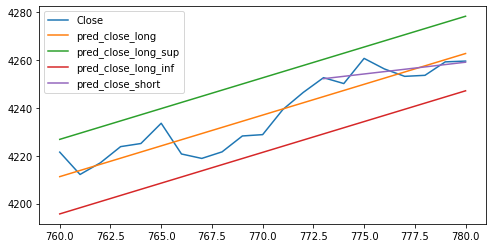

In [73]:
df_obs = Xout[['Close','pred_close_long','pred_close_long_sup','pred_close_long_inf','pred_close_short']]

print(max(df_analisys['Datetime']))
print(max(Datetime['Datetime']))
df_obs.plot(figsize=(8,4))

In [74]:
df_info_01.iloc[9:21,:]

,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,mean_last_macd,mean_last_macdh,pp_vol_last2,pp_body_size_last2,...,pp_red_vol_last2,pp_green_size_last2,pp_red_size_last2,pp_greenored,range_obs,mean_upper_tail_size,std_upper_tail_size,mean_lower_tail_size,std_lower_tail_size,Datetime
9,-57.505605,67.50128,20.402639,2.146072,1.0,43.096921,-10.087819,-0.892749,0.057754,0.075003,...,0.0,0.075003,0.0,0.909091,80.560059,2.82094,2.635102,3.326707,2.323173,2022-03-10 13:45:00
10,-66.981236,28.956626,15.631061,1.096731,0.0,26.724857,-10.693621,-1.721739,0.057058,0.048092,...,0.0,0.048092,0.0,0.909091,80.560059,2.759045,2.640515,3.326707,2.323173,2022-03-10 13:30:00
11,-71.055463,13.295573,17.905143,1.014954,0.0,10.601433,-10.932138,-2.390691,0.057499,0.060673,...,0.0,0.060673,0.0,0.75,80.560059,2.675246,2.600126,3.301944,2.333828,2022-03-10 13:15:00
12,-74.11775,1.619088,14.253577,0.669738,0.0,-1.165885,-11.174288,-3.230513,0.055385,0.029942,...,0.027564,0.017466,0.012476,0.75,80.560059,2.694778,2.596732,3.26051,2.386295,2022-03-10 13:00:00
13,-75.804026,29.279124,12.303952,0.514006,0.0,2.226923,-11.25668,-4.120533,0.053996,0.098189,...,0.053996,0.0,0.098189,0.75,80.560059,2.652855,2.586776,3.34289,2.407346,2022-03-10 12:45:00
14,-76.861678,56.133655,13.530714,0.521566,0.0,7.9425,-11.242703,-5.13669,0.054108,0.139955,...,0.026351,0.05563,0.084325,0.909091,80.560059,2.789039,2.677991,3.256696,2.472431,2022-03-10 12:30:00
15,-77.639467,60.087731,25.061504,0.90698,0.0,-2.329944,-11.023659,-6.201818,0.054218,0.069128,...,0.0,0.069128,0.0,0.909091,80.560059,2.855701,2.62193,3.373349,2.426438,2022-03-10 12:15:00
16,-78.796542,-39.968792,17.256925,0.564472,0.0,-36.644807,-10.409422,-7.138035,0.056551,0.0557,...,0.0,0.0557,0.0,0.75,80.560059,2.760463,2.682936,3.322893,2.48486,2022-03-10 12:00:00
17,-79.23276,-71.189769,13.549372,0.42552,0.0,-54.070225,-9.228435,-7.741557,0.067975,0.079064,...,0.0,0.079064,0.0,0.75,80.560059,2.660482,2.734112,3.347656,2.468219,2022-03-10 11:45:00
18,-79.399255,-78.944226,3.189162,0.098571,0.0,-63.017902,-7.534493,-7.983005,0.075166,0.099255,...,0.037462,0.034058,0.065197,0.615385,80.560059,2.640951,2.752394,3.488118,2.609798,2022-03-10 11:30:00


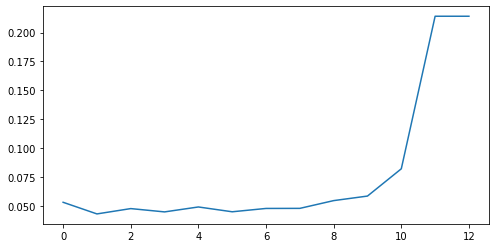

In [225]:

df_obs2= X['pp_vol'].reset_index(drop=True)


df_obs2.plot(figsize=(8,4))

In [193]:
df_obs = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)==False]

df_obs

,slope_close,diff_closewpred_close,diff_closewfore_close,diff_closewpred_closepred,pp_vol_last2,pp_body_size_last2,mean_green_candles_sizes,std_green_candles_sizes,mean_red_candles_sizes,std_red_candles_sizes,...,range_obs,mean_upper_tail_size,std_upper_tail_size,mean_lower_tail_size,std_lower_tail_size,recent_macd_cross,slope_macd,mean_last_macd,mean_last_macdh,Datetime
748,-1.841545,-10.594604,-12.436149,-1.684545,0.347748,0.277478,8.162598,4.466262,36.580078,0.0,...,36.69043,2.104102,1.876641,8.741992,6.759831,0.0,1.754173,-11.516463,NaN,2022-01-27 11:00:00
749,-5.747378,-11.902162,-17.64954,-1.146107,0.349432,0.251221,7.782593,4.799038,36.580078,0.0,...,36.69043,3.084082,3.95153,8.944043,6.634709,0.0,1.236786,-12.99942,NaN,2022-01-27 10:45:00
750,-6.506712,1.79023,-4.716482,0.160347,0.370406,0.47108,12.120117,12.831622,36.580078,0.0,...,36.69043,3.036035,3.982717,7.402051,7.788801,0.0,1.953242,-15.067896,NaN,2022-01-27 10:30:00
751,15.990052,36.396881,52.386933,7.906647,0.275515,0.528692,12.857544,12.24154,36.580078,0.0,...,78.94043,5.158008,4.797221,6.67998,7.031949,0.0,3.356733,-17.744418,NaN,2022-01-27 10:15:00
752,25.780424,10.024687,35.805112,-0.147285,0.306654,0.258658,12.857544,12.24154,3.159668,0.0,...,85.350098,6.148047,4.382596,10.566016,7.749713,0.0,4.576953,-21.377009,NaN,2022-01-27 10:00:00
753,21.180134,-8.189297,12.990837,-6.889297,0.291513,0.579562,14.324951,12.128138,3.159668,0,...,75.47998,5.660059,4.979907,12.058105,9.547826,0,None,-23.643637,NaN,2022-01-27 09:45:00
754,13.30373,-36.272474,-22.968744,-13.15431,0.497332,0.353686,17.709961,12.324278,26.179688,32.555224,...,83.390137,3.664062,4.812806,13.076074,9.000107,0,None,-25.932367,NaN,2022-01-27 09:30:00
755,-3.48659,-5.3639,-8.85049,3.879948,0.527287,0.107874,11.129883,6.632579,22.243164,24.008539,...,49.339844,3.488086,4.954071,16.686035,5.305725,0,None,-28.351169,NaN,2022-01-26 15:45:00
756,-13.488303,-11.234857,-24.72316,0.561139,0.407043,0.159788,15.819824,0,25.739868,20.813002,...,65.279785,2.130078,3.018179,14.396094,9.184067,0,None,NaN,NaN,2022-01-26 15:30:00
757,-23.290916,-16.912207,-40.203123,-0.052246,0.433706,0.471431,19.059814,4.582038,33.266602,17.602877,...,101.759766,1.428027,1.935322,11.146094,9.8111,0,None,NaN,NaN,2022-01-26 15:15:00


In [194]:
#df.index[np.isinf(df).any(1)]

df_insights_info_tr_01 = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)]
df_insights_info_tr_01 = df_insights_info_tr_01.reset_index(drop=True)
print(df_insights_info_tr_01.shape)

df_insights_info_tr_01.info()

(748, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   slope_close                748 non-null    object        
 1   diff_closewpred_close      748 non-null    object        
 2   diff_closewfore_close      748 non-null    object        
 3   diff_closewpred_closepred  748 non-null    object        
 4   pp_vol_last2               748 non-null    object        
 5   pp_body_size_last2         748 non-null    object        
 6   mean_green_candles_sizes   748 non-null    object        
 7   std_green_candles_sizes    748 non-null    object        
 8   mean_red_candles_sizes     748 non-null    object        
 9   std_red_candles_sizes      748 non-null    object        
 10  pp_green_candles_vols      748 non-null    object        
 11  pp_red_candles_vols        748 non-null    object        
 12

In [195]:
df_insights_info_tr_01[[
    'pp_green_vol_last2',
    'pp_red_vol_last2',
    'pp_green_size_last2',
    'pp_red_size_last2',
]]

,pp_green_vol_last2,pp_red_vol_last2,pp_green_size_last2,pp_red_size_last2
0,0.0,0.687529,0.0,0.473232
1,0.0,0.648688,0.0,0.454159
2,0.201169,0.282683,0.014811,0.048086
3,0.446063,0.0,0.591828,0.0
4,0.223592,0.195956,0.498925,0.137181
...,...,...,...,...
743,0.0,0.40177,0.0,0.5019
744,0.0,0.355775,0.0,0.339271
745,0.188612,0.158901,0.248526,0.008588
746,0.16919,0.187136,0.235824,0.378776


In [196]:
#df_y = pd.DataFrame(yhat.tolist(),columns=['yhat'])
#df_y['yhat2'] = yhat2
#df_y['y'] = X['Close'].reset_index(drop=True)

#df_y[['yhat','yhat2','y']].plot(figsize=(12,8))
#df_y

#diff_closewpred_close = yhat[-1][0] - y[-1][0]
#diff_closewpred_close
#yhat[-1][0]
#y

# Target signal

In [260]:
df_analisys = df_analisys.sort_values(['Datetime'])
df_analisys = df_analisys.reset_index(drop=True)
print(df_analisys.shape)

(778, 18)


In [261]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    nro_steps = 3
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        
        Datetime = df_analisys['Datetime'][i]
        target_date = df_analisys['Datetime'][i+nro_steps]
        
        target_close = df_analisys['Close'].iloc[i+nro_steps]
        target_profit = df_analisys['Close'][i] - target_close


        
        
        ls_results = [Datetime,target_date,target_close,target_profit]
        df_results = pd.DataFrame(np.array([ls_results]),columns=['Datetime','target_date','target_close','target_profit'])
        
        
        if i == 0:
            df_target =df_results.copy()
        else:
            df_target =df_target.append(df_results).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,Datetime,target_date,target_close,target_profit
0,2022-01-27 09:30:00,2022-01-27 10:15:00,4389.509766,21.94043
1,2022-01-27 09:45:00,2022-01-27 10:30:00,4392.810059,23.52002
2,2022-01-27 10:00:00,2022-01-27 10:45:00,4406.290039,19.910156
3,2022-01-27 10:15:00,2022-01-27 11:00:00,4411.870117,-22.360352
4,2022-01-27 10:30:00,2022-01-27 11:15:00,4389.799805,3.010254
...,...,...,...,...
770,2022-03-10 13:30:00,2022-03-10 14:15:00,4252.589844,-23.799805
771,2022-03-10 13:45:00,2022-03-10 14:30:00,4250.129883,-10.810059
772,2022-03-10 14:00:00,2022-03-10 14:45:00,4260.640137,-14.220215
773,2022-03-10 14:15:00,2022-03-10 15:00:00,4257.040039,-4.450195


In [262]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['Datetime'],
                         how = 'left').copy()

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_profit'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(778, 18)
(778, 21)
          index  target_profit
253  -91.309570              1
215  -78.959961              1
216  -71.819824              1
579  -63.850098              1
230  -63.489746              1
..          ...            ...
382   67.280273              1
221   67.770020              1
420   73.959961              1
185  108.200195              1
0           NaN              3

[746 rows x 2 columns]


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit
0,2022-01-27 09:30:00,4380.580078,4412.330078,4380.580078,4411.450195,4411.450195,114210975,2022-01-27,30.870117,30.870117,...,0.000000,1,NaN,NaN,NaN,NaN,NaN,2022-01-27 10:15:00,4389.509766,21.94043
1,2022-01-27 09:45:00,4412.160156,4426.310059,4406.129883,4416.330078,4416.330078,157150563,2022-01-27,4.169922,4.169922,...,6.030273,1,NaN,NaN,NaN,NaN,NaN,2022-01-27 10:30:00,4392.810059,23.52002
2,2022-01-27 10:00:00,4416.250000,4428.740234,4400.330078,4426.200195,4426.200195,120682154,2022-01-27,9.950195,9.950195,...,15.919922,1,NaN,NaN,NaN,NaN,NaN,2022-01-27 10:45:00,4406.290039,19.910156
3,2022-01-27 10:15:00,4426.089844,4427.729980,4389.509766,4389.509766,4389.509766,115150727,2022-01-27,-36.580078,36.580078,...,0.000000,0,NaN,NaN,NaN,NaN,NaN,2022-01-27 11:00:00,4411.870117,-22.360352
4,2022-01-27 10:30:00,4389.319824,4392.950195,4374.259766,4392.810059,4392.810059,115498034,2022-01-27,3.490234,3.490234,...,15.060059,1,NaN,NaN,NaN,NaN,NaN,2022-01-27 11:15:00,4389.799805,3.010254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,2022-03-10 14:15:00,4246.410156,4254.339844,4245.419922,4252.589844,4252.589844,57103000,2022-03-10,6.179688,6.179688,...,0.990234,1,-4.123882,3.559063,-7.682945,8.144069,-26.904441,2022-03-10 15:00:00,4257.040039,-4.450195
774,2022-03-10 14:30:00,4252.560059,4257.879883,4249.500000,4250.129883,4250.129883,63334000,2022-03-10,-2.430176,2.430176,...,0.629883,0,-2.680272,4.002138,-6.682410,5.461202,-29.072219,2022-03-10 15:04:44,4252.549805,-2.419922
775,2022-03-10 14:45:00,4249.729980,4264.509766,4249.729980,4260.640137,4260.640137,69380000,2022-03-10,10.910156,10.910156,...,0.000000,1,-0.680270,4.801712,-5.481982,15.345124,-18.377269,NaT,NaN,NaN
776,2022-03-10 15:00:00,4260.669922,4261.669922,4255.649902,4257.040039,4257.040039,19914000,2022-03-10,-3.629883,3.629883,...,1.390137,0,0.607249,4.871385,-4.264136,11.284437,-21.758686,NaT,NaN,NaN


In [263]:
df_varbins = df_analisys_01[['target_profit']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_profit'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_bins
20                 00-nan            3
3   01-(-91.311, -30.019]           39
7   02-(-30.019, -21.566]           39
4   03-(-21.566, -16.953]           39
17  04-(-16.953, -14.262]           38
9    05-(-14.262, -10.83]           39
6     06-(-10.83, -8.718]           39
15    07-(-8.718, -6.475]           38
2     08-(-6.475, -3.648]           39
10    09-(-3.648, -1.601]           39
8    10-(-1.601, 0.00977]           39
18    11-(0.00977, 1.828]           38
14      12-(1.828, 3.838]           39
1        13-(3.838, 6.47]           39
19        14-(6.47, 9.06]           38
5       15-(9.06, 11.475]           39
13     16-(11.475, 14.81]           39
0       17-(14.81, 18.75]           39
16     18-(18.75, 24.614]           38
11    19-(24.614, 35.751]           39
12     20-(35.751, 108.2]           39


In [268]:
mean_time = abs(df_varbins['target_profit']).mean()
print('Mean profit: ', mean_time)

Mean profit:  15.108711567540322


In [201]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['Datetime']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit,target_date_diff
0,2022-01-26 09:30:00,4408.430176,4424.770020,4403.020020,4406.649902,4406.649902,93410340,2022-01-26,-1.780273,1.780273,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-26 10:15:00,4405.220215,1.429688,45.0
1,2022-01-26 09:45:00,4406.830078,4436.930176,4406.830078,4432.410156,4432.410156,123034861,2022-01-26,25.580078,25.580078,...,1,NaN,NaN,NaN,NaN,NaN,2022-01-26 10:30:00,4393.600098,38.810059,45.0
2,2022-01-26 10:00:00,4433.220215,4444.830078,4424.520020,4425.799805,4425.799805,107898177,2022-01-26,-7.420410,7.420410,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-26 10:45:00,4405.299805,20.5,45.0
3,2022-01-26 10:15:00,4425.580078,4429.939941,4400.970215,4405.220215,4405.220215,107347769,2022-01-26,-20.359863,20.359863,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-26 11:00:00,4418.25,-13.029785,45.0
4,2022-01-26 10:30:00,4405.250000,4407.950195,4392.250000,4393.600098,4393.600098,96400671,2022-01-26,-11.649902,11.649902,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-26 11:15:00,4420.470215,-26.870117,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-09 15:00:00,4278.439941,4294.180176,4278.439941,4292.259766,4292.259766,80380000,2022-03-09,13.819824,13.819824,...,1,12.215458,-0.985749,13.201206,34.545259,1.854724,2022-03-09 15:45:00,4277.549805,14.709961,45.0
777,2022-03-09 15:15:00,4292.339844,4295.390137,4287.430176,4292.700195,4292.700195,86204000,2022-03-09,0.360352,0.360352,...,1,12.419722,-0.625187,13.044909,33.613701,2.272316,2022-03-09 16:00:00,4277.879883,14.820312,45.0
778,2022-03-09 15:30:00,4292.560059,4299.399902,4288.540039,4291.390137,4291.390137,121134000,2022-03-09,-1.169922,1.169922,...,0,12.333717,-0.568954,12.902671,31.036833,0.952683,NaT,NaN,NaN,NaN
779,2022-03-09 15:45:00,4291.339844,4294.209961,4271.939941,4277.549805,4277.549805,316533000,2022-03-09,-13.790039,13.790039,...,0,11.021707,-1.504771,12.526478,16.522128,-12.759414,NaT,NaN,NaN,NaN


In [202]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                 index  target_date_bins
2               00-nan                 3
0  01-(44.999, 1095.0]               760
1  02-(1095.0, 5415.0]                18


In [203]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

45.0

In [204]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    45.0
dtype: float64


In [205]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_profit'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_profit'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_profit'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_profit'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'].isin(['BUY','BUY2']), 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
1    BUY           345
2   BUY2            46
4   NULL             4
0   SELL           346
3  SELL2            40
   index  target_order_bin
1      0               390
0      1               391


# Attaches target variable to the df with transformations

In [206]:
ls_tgcols = [
    'date',
    'Datetime',
    'Close',
    'target_order',
    'target_order_bin',
    'target_close',
    'target_profit',
    'target_date',
    'target_date_diff',
]


df_transformations_100 = pd.merge(df_close_info_tr_01,
                           df_vols_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_transformations_100 = pd.merge(df_transformations_100,
                           df_movs_low_vols[['Datetime','movs_low_vols']],
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_transformations_100 = pd.merge(df_transformations_100,
                           df_insights_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_01[ls_tgcols],
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['Datetime']).reset_index(drop=True)

print(df_analisys_100.shape)

df_analisys_100


(678, 48)


,Datetime,last_ss_close,mean_last3_ss_close,slope_ss_close,ss1_close_c1,ss1_close_c2,ss1_close_c3,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,...,mean_last_macd,mean_last_macdh,date,Close,target_order,target_order_bin,target_close,target_profit,target_date,target_date_diff
0,2022-01-31 15:45:00,2.015975,1.724293,0.257326,5.416220,-8.241853,1.675721,4.549757,1.609183,-0.123922,...,20.284357,-3.185415,2022-01-31,4515.439941,BUY2,1,4503.939941,11.5,2022-02-01 10:00:00,1095.0
1,2022-02-01 09:30:00,1.804584,1.792187,0.097910,5.733586,-8.157090,1.286628,0.240024,1.731479,-0.116516,...,19.9851,-2.787738,2022-02-01,4506.270020,BUY,1,4501.950195,4.319824,2022-02-01 10:15:00,45.0
2,2022-02-01 09:45:00,1.845984,1.837429,-0.032553,6.063702,-8.018952,0.955312,0.578386,1.780601,-0.104316,...,20.030034,-2.194243,2022-02-01,4511.609863,BUY,1,4497.120117,14.489746,2022-02-01 10:30:00,45.0
3,2022-02-01 10:00:00,1.677264,1.733134,-0.019527,6.403840,-7.828086,0.657580,0.536370,0.443760,-0.093282,...,20.016258,-1.766415,2022-02-01,4503.939941,SELL,0,4513.870117,-9.930176,2022-02-01 10:45:00,45.0
4,2022-02-01 10:15:00,1.609418,1.673671,-0.079919,6.734583,-7.609303,0.372795,0.199421,0.431419,-0.100463,...,19.508334,-1.819472,2022-02-01,4501.950195,SELL,0,4522.0,-20.049805,2022-02-01 11:00:00,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,2022-03-09 15:00:00,0.797089,0.616072,0.113807,-3.385407,-7.743515,2.087533,-0.533085,-0.668906,-0.062209,...,12.36936,-1.301737,2022-03-09,4292.259766,BUY,1,4277.549805,14.709961,2022-03-09 15:45:00,45.0
674,2022-03-09 15:15:00,0.821492,0.708631,0.164185,-2.962249,-7.990245,1.909339,-0.403924,-0.550984,-0.054081,...,12.25041,-1.136549,2022-03-09,4292.700195,BUY,1,4277.879883,14.820312,2022-03-09 16:00:00,45.0
675,2022-03-09 15:30:00,0.793081,0.809947,-0.010093,-2.573878,-8.236807,1.563711,0.308907,-0.206636,-0.038606,...,12.197701,-0.951407,2022-03-09,4291.390137,NULL,0,NaN,NaN,NaT,NaN
676,2022-03-09 15:45:00,0.480061,0.705435,-0.176668,-2.209658,-8.409985,1.183422,3.915182,1.249156,0.082593,...,11.997651,-0.921165,2022-03-09,4277.549805,NULL,0,NaN,NaN,NaT,NaN


In [207]:
print(df_analisys_100.shape)
print(min(df_analisys_100['Datetime']))
print(max(df_analisys_100['Datetime']))

(678, 48)
2022-01-31 15:45:00
2022-03-09 16:00:00


In [208]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           302
2   BUY2            43
4   NULL             4
1   SELL           297
3  SELL2            32


In [209]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(678, 48)
2022-03-09 20:25:14.547205
